In [39]:
pip install flopy

Note: you may need to restart the kernel to use updated packages.


# Transient

## Model Description 
This intially constructs the 3D (homogeneous) steady state box model that you built for your BoxModel_Manual assignment

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 10 m
- dz = 50 m  
- the model is unconfined

#### Subsurface Properties: 
- Homogeneous 
- K = 0.1 m/day in x, y and z 
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is a constant head of 30 m relative to the datum, which is located at the bottom of the domain. 
 - Left boundary is a constant head of 50 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 1E-5 m/d uniformly across the domain
 - There is no ET in the domain

#### Initial Conditions: 
 - Set the initial head to 50 everywhere, which will be replaced by the initial steady state solution

#### Pumpinmg
 - Well located at row, column 20,20
     - There is no pumping during the initial steady state period
     - Case 1: pumps at a rate of 500 m3/d for 90 days, then zero for remaining 270 days of the year for 50 years. (Assume a 360 day year made of 12 30-day months for simplicity of plotting.)

#### The Challenges
  - The gradient is not uniform for the initial steady state conditions - discuss the influences of recharge and the unconfined condition on this nonlinearity
  - Determine if the system has reached steady state - consider a point at the well and another at the center of the domain.  
  - Find the zone of influence of the well defined in two ways:
      - Based on the drawdown from the initial steady state to the end of simulation time (end of final no-pumping stress period).
      - Based on the drawdown from the end of the last pump-on stress period to the end of simulation time.
  - How long does it take a point at the center of the domain to reach steady state.  At that point, explain how you could divide the domain into a steady and transient part and solve each separately.
  - Find a constant pumping rate (same throughout the year) that matches the head time series at the middle of the domain.  
  - Find a constant pumping rate (same throughout the year) that matches the head time series at the well, leaving only a regular, repeating seasonal residual.  Are the two pumping rates the same?
  - Discuss the sources of water captured by this well.  If you're up for a challenge, calculate them for the final pump-on period!
  - Discuss how you would define the capture zone of the well.  How is it different than our definitions of capture zone so far in the course?



## 1. Setup the environment

In [40]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Create the model object

In [41]:
modelname = "transient_layer_parts/particles" # this part important - QH
# *NOTE Be careful about where things be located!
moddir="../../../pymake/examples/mf2005" # this part important - QH

# added dis file
m = flopy.modflow.Modflow(modelname, exe_name=moddir)


In [42]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch','evt']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [43]:
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers # multiple layers

dx= 10 #width of grid cells in x direction 
dy= 10 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 50.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

domain_centerpt = (0, int(nrow/2), int(ncol/2))   # used for plotting

#### 3.2 Temporal discretization 

In [44]:
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type



sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 270       # Length of stress period 1 in days
sp2_len = 360-sp1_len      # Length of stress period 2 in days
sim_years = 100      #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

nstp=perlen/30 # set monthly time steps per stress period to get monthly results
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)

elyears = (np.cumsum(perlen)-perlen[0])/360


#### 3.3 Create DIS object

In [45]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

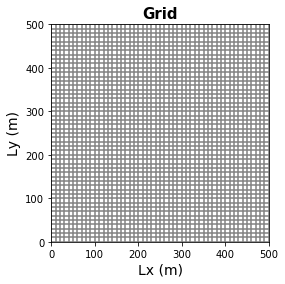

In [46]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()


## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [47]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 


#### 4.2 Define starting heads 

In [48]:
#setup initial heads as 70 everywhere, this value will be preserved on constant head boundaries  
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 50    # set all values to uniform initial condition
H_init[:, :, -1] = 30    #replace last (left) col with desired head value


#### 4.3 Create BAS object

In [49]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

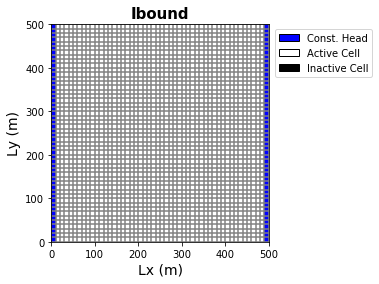

In [50]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)


# I'm not sure why this stopped working!  Can someone figure out why the right boundary doesn't show up as constant head??

## 5. Setup Layer Properties  (LPF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

#### 5.1 Set layer properties

In [51]:
K_horiz = 0.1    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.03        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

#### 5.2 Make LPF object

In [52]:
# kept in case you want to use it later

#assigns horizontal and vertical Ks and saves cell-by-cell budget data
# lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
#                                vka=K_vert, ss=Ss,
#                                sy=Sy,storagecoefficient=True, ipakcb=53) 


## 5b. Setup Cell-byCell Properties  (BCF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html

#### 5b.1 Set cell properties and show K in top layer

1.0


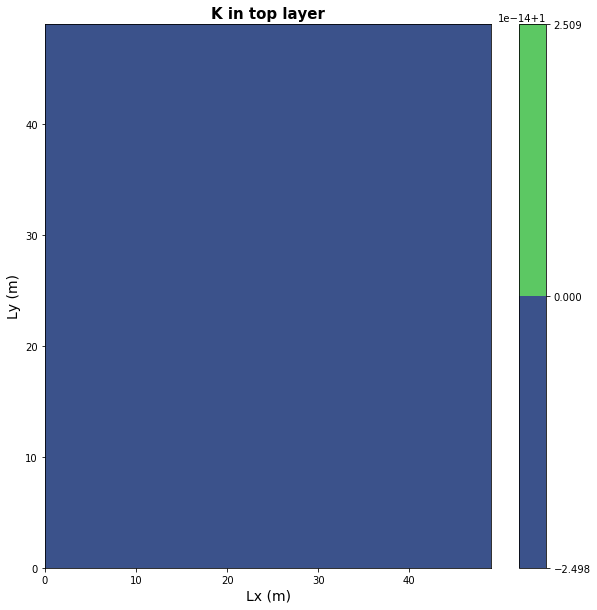

In [53]:
K_vals = np.zeros((ncol,nrow,nlay))
K_vals[:,:,:] = 1           # homoogeneous background hydraulic conductivity 
#K_vals[10:15,10:15,:] = 0.1   # low K inclusion

print(K_vals[0,0,0])

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
plt.contourf(K_vals[:,:,0])
plt.colorbar()
plt.show()

#### 5b.2 Make BCF object

In [54]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[:,:,0], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [55]:
#create oc stress period data - save for each time step in each stress period. 
oc_spd = {}
for kper in range(nper):  
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']


#### 6.2 Make OC object 

In [56]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [57]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [58]:
#Setup alternating pumping values

well_loc = [0, 20, 20] # QH Changed


Q1 = -260
Q2 = -260 
Q_val=np.tile([Q1, Q2],sim_years)
Q_val=np.append(0,Q_val) # add a period of length 10 at the start for the steady state simulation
                      
Q = {}
for p in range(0,nper):    #loop over stress periods
    Q[p]=Q_val[p]

well_spd = {}                                                                                                     # create empty dictionary for well info
for per in range(nper):                                                                                       # transient models, iterate over stress periods to assign well stresses
    well_spd[per] = [[well_loc[0], well_loc[1], well_loc[2], Q_val[per]]]     # assign well coord & pump rate for each stress period

#### 8.2 Make the WEL object

In [59]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=well_spd)  #create object for WEL package

##9. Add recharge (RCH Package)

For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfrch.html

#### 9.1 Setup recharge value

In [60]:
#Recharge 
rech_zone = np.ones((nrow,ncol))               #define an array of zeros of dim (nrow,ncol) - backgroun ET is zero everywhere
recharge = 5e-4 #m/day                          
rech_zone = rech_zone*recharge
print(rech_zone)

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


[[0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 ...
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]
 [0.0005 0.0005 0.0005 ... 0.0005 0.0005 0.0005]]


9.2 Add evapotranspiration

In [61]:
# # ET - this is set up to show how you would add time-varying recharge in a localized area
# ET_val1 = 0 #m/day
# ET_val2 = 0.01 #m/day
# ET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate
# extinction_depth = 50

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
# ET_centerpt=(0, int(np.mean(ET_rows)),int(np.mean(ET_cols)))
# ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
# ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET_val2  # assign ET rate to the ET zone

# #Setup alternating ET values
# ET_val=np.tile([ET_val1, ET_val2],sim_years)
# ET_val=np.append(ET_val1,ET_val) # add a period of length 10 at the start for the steady state simulation
                      
# ET = {}
# for p in range(0,nper):    #loop over stress periods
#     ET[p]=ET_zone*ET_val[p]

# evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 


## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [62]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [63]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: ../../../pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: transient_layer_parts/particles.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/27 17:09:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.


Exception: MODFLOW did not terminate normally.

## 11. Plot the results  

#### 11.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile



In [ ]:
# QH - Moving Average:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


# Read the heads 
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data

# hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
# times = hds.get_times() # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
head = []
headarray=np.zeros((len(times),ncol,nrow))
frf=np.zeros((len(times),ncol,nrow))
fff=np.zeros((len(times),ncol,nrow))
rowcounter=-1
for i in times:
    rowcounter+=1
    temphead = headobj.get_data(totim=i) #append heads to head list for each stress per
    headarray[rowcounter,:,:] = temphead
    tempfrf = np.squeeze(budgobj.get_data(text='flow right face',totim=i))
    # print(tempfrf)
    frf[rowcounter,:,:] = tempfrf
    tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE',totim=i))
    fff[rowcounter,:,:] = tempfff

# extract and plot head time series at specific points
time_series1 = headarray[:,domain_centerpt[1],domain_centerpt[2]]
time_series2 = headarray[:,well_loc[1],well_loc[2]]


n_in = 8
time_series1_mv = moving_average(time_series1,n_in)
time_series2_mv = moving_average(time_series2,n_in)
elyears_mv = elyears[int(n_in/2)-1:-int(n_in/2)]

tol = 5e-5 # the tolerance to set as 'steady'
# locate steady state
time_series1_mv_diff = time_series1_mv[:-1] - time_series1_mv[1:]
time_series2_mv_diff = time_series2_mv[:-1]  - time_series2_mv[1:]

# first year where head does not change
print('the first steady state year at well is,', elyears_mv[:-1][time_series1_mv_diff < tol][0])
print('the first steady state year at midpoint is,', elyears_mv[:-1][time_series2_mv_diff <= tol][0])


# # QH Extra Time Series (pumping 250 both periods)
# time_series3 = time_series1 # mid
# time_series4 = time_series2 # well


fig1 = plt.figure(figsize=(10,10))
plt.title("Head at well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
# plt.xlim(0,2)

plt.plot(elyears, time_series2, 'r-', alpha=0.8, label='var 500 m/d') #plot the time series with points at each record
# plt.plot(elyears, time_series4, label='const 250 m/d')
plt.plot(elyears_mv, time_series2_mv, 'black', alpha = 0.8, label='moving avg')
plt.legend()
plt.show()

fig2 = plt.figure(figsize=(10,10))
plt.title("Head at midpoint",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(elyears, time_series1, 'r-', alpha = 0.8, label='var 500 m/d') #plot the time series with points at each record
# plt.plot(elyears, time_series3, label='const 250 m/d')
plt.plot(elyears_mv, time_series1_mv, 'black', alpha = 0.8, label='moving avg')
plt.legend()
plt.show()




# Particle Tracking (simple)
### Forward particle tracking

In [ ]:
# create nodes
def get_nodes(locs):
    nodes = []
    for k, i, j in locs:
        nodes.append(k * nrow * ncol + i * ncol + j)
    return nodes

nodew = get_nodes([well_loc])
# nodesr = 

print(nodew)
# cellids = m.riv.stress_period_data.get_data()[0]['cellid']
# nodesr = get_nodes(cellids)
# nodew = get_nodes([[1, 1, 20]])

mpdir="../../../pymake/examples/mp7"  
nm = modelname
mpnamf = nm + '_mp_forward'

n = 1

# create basic forward tracking modpath simulation
mp = flopy.modpath.Modpath7.create_mp7(modelname=mpnamf, trackdir='forward', flowmodel=m, model_ws=None, 
                                       rowcelldivisions=n, columncelldivisions=n, layercelldivisions=n,
                                       exe_name=mpdir)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

# print(fpth)

# forward path
ws = ''
fpth = os.path.join(ws, mpnamf + '.mppth')
p = flopy.utils.PathlineFile(fpth)
pw = p.get_destination_pathline_data(dest_cells=nodew)
# pr = p.get_destination_pathline_data(dest_cells=nodesr)

# forward enpoint
fpth = os.path.join(mpnamf + '.mpend')
e = flopy.utils.EndpointFile(fpth)

# forward particles ending at well
well_epd = e.get_destination_endpoint_data(dest_cells=nodew)

# well forward tracking pathlines, plotting
colors = ['green', 'orange', 'red']
f, ax = plt.subplots(figsize=(7, 7))
# axes = axes.flatten()

idax = 0
k = 0
ax.set_aspect('equal')
ax.set_title('Forward Well pathlines - Layer {}'.format(k+1))
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw, layer=k, color=colors[k], lw=0.75)

    
plt.tight_layout()

# forward tracking endpoints captured by well

f, ax = plt.subplots(figsize=(7, 7))

ax.set_aspect('equal')
ax.set_title('Well recharge area')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_endpoint(well_epd, direction='starting', colorbar=True, shrink=0.5)


### Backward particle tracking

In [ ]:
# help(p.get_alldata) 
# help(p.get_alldata)
# help(e)
help(mm.plot_pathline)

In [ ]:
print(pall)
# pall = p.get_alldata(totim=1, ge=False)
# print(pall)
# print(ewb)

In [ ]:
# create modpath files
mpnamb = nm + '_mp_backward'


# well_loc_o = well_loc
n = 5

# create basic forward tracking modpath simulation
mp = flopy.modpath.Modpath7.create_mp7(modelname=mpnamb, trackdir='backward', flowmodel=m, model_ws=None, 
                                       rowcelldivisions=n, columncelldivisions=n, layercelldivisions=n,
                                       nodes=nodew[0], exe_name=mpdir) # nodes=nodew+nodesr

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

# backward tracking pathlines
fpth = os.path.join(mpnamb + '.mppth')
p = flopy.utils.PathlineFile(fpth)
pwb = p.get_destination_pathline_data(dest_cells=nodew)
# all data
pall = p.get_alldata(totim=10, ge=False)
pall = p.get_alldata()
# prb = p.get_destination_pathline_data(dest_cells=nodesr)

# backward tracking endpionts
fpth = os.path.join(mpnamb + '.mpend')
e = flopy.utils.EndpointFile(fpth)
ewb = e.get_destination_endpoint_data(dest_cells=nodew, source=True)
# all data
# eall = e.get_alldata(totim=10, ge=False)
eall = e.get_alldata
# erb = e.get_destination_endpoint_data(dest_cells=nodesr, source=True)


# # ones
# f, ax = plt.subplots(figsize=(7, 7))

# ax.set_aspect('equal')
# ax.set_title('Well recharge area')
# mm = flopy.plot.PlotMapView(model=m, ax=ax)
# mm.plot_grid(lw=0.5)
# mm.plot_pathline(pwb, layer='all', color='blue', lw=0.5, linestyle=':', label='captured by wells')
# mm.plot_endpoint(ewb, direction='ending') #, colorbar=True, shrink=0.5);

# plt.tight_layout()


# alls
f, ax = plt.subplots(figsize=(3, 3))

ax.set_aspect('equal')
ax.set_title('Well recharge area')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, travel_time=10000, layer='all', color='blue', lw=0.5, linestyle=':', label='captured by wells')
# mm.plot_endpoint(eall, direction='ending') #, colorbar=True, shrink=0.5);

plt.tight_layout()




## Plot head distributions after initial steady state, after final off pumping period, and at end of simulation

In [ ]:
## Plot head cross section through well after initial steady state, after final off pumping period, and at end of simulation

In [ ]:
#plot head distribution at years 0, half of sim time, end of sim time
# initsteady = headarray[0,20,:]
plt.plot(np.arange(nrow),headarray[0,20,:],'r',label='steady state')
plt.plot(np.arange(nrow),headarray[-2,20,:],'b',label='final off')
plt.plot(np.arange(nrow),headarray[-1,20,:],'g',label='final time')
# plt.plot(np.arange(nrow),initsteady,'b-',label='steady state')
plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.legend()
plt.show()


for i in range(1,headarray.shape[0], 2):
    plt.plot(np.arange(nrow),headarray[i,20,:],alpha=0.2)

plt.xlabel('Column number')
plt.ylabel('Head (m)')
plt.title('Approaching steady state at end of off period')
plt.show()



In [ ]:
#plot head distribution at years 0, half of sim time, end of sim time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[0,:,:], levels=contour_levels) #create head contours   
tempfrf3 = frf[0,:,:].reshape(1,ncol,nrow)
tempfff3 = fff[0,:,:].reshape(1,ncol,nrow)
temphead3 = headarray[0,:,:].reshape(1,ncol,nrow)
flows = modelmap.plot_discharge(tempfrf3, tempfff3, head=temphead3) #create discharge arrows
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Head (m) at initial steady state', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

fig2 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[-1,:,:], levels=contour_levels) #create head contours   
tempfrf1 = frf[-1,:,:].reshape(1,ncol,nrow)
tempfff1 = fff[-1,:,:].reshape(1,ncol,nrow)
temphead1 = headarray[-1,:,:].reshape(1,ncol,nrow)
flows = modelmap.plot_discharge(tempfrf1, tempfff1, head=temphead1) #create discharge arrows
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Head (m) at end of simulation', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

fig3 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(headarray[0].min(),headarray[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[-2,:,:], levels=contour_levels) #create head contours   
tempfrf2 = frf[-2,:,:].reshape(1,ncol,nrow)
tempfff2 = fff[-2,:,:].reshape(1,ncol,nrow)
temphead2 = headarray[-2,:,:].reshape(1,ncol,nrow)
flows = modelmap.plot_discharge(tempfrf2, tempfff2, head=temphead2) #create discharge arrows
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Head (m) at end of final off period', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)



## Plot drawdown

In [ ]:
#plot change in head distribution between steady state and final time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_min = np.min(headarray[0,:,:]-headarray[-1,:,:])
contour_max = np.max(headarray[0,:,:]-headarray[-1,:,:])
contour_levels = np.linspace(contour_min,contour_max,21) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[0,:,:]-headarray[-1,:,:], levels=contour_levels) #create head contours   
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown (m) from steady state to final time', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

#plot change in head distribution between steady state and final time
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_min = np.min(headarray[-2,:,:]-headarray[-1,:,:])
contour_max = np.max(headarray[-2,:,:]-headarray[-1,:,:])
contour_levels = np.linspace(contour_min,contour_max,21) #set contour levels for contouring head
head_contours = modelmap.contour_array(headarray[-2,:,:]-headarray[-1,:,:], levels=contour_levels) #create head contours   
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Drawdown (m) from final off to final time', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

